In [94]:
import pandas as pd
import numpy as np
url="https://raw.githubusercontent.com/wangjk321/Intragenic-cohesin-project/master/March2020/bino161_normalizedContinuous15.matrix"
mt = pd.read_csv(url,sep="\t")
mt.index=mt.CohesinPos
mt.shape
mt.drop("CohesinPos",axis=1,inplace=True)

In [95]:
y=(mt["Mvalue_continue"]<-0.5) & (mt["cohesin.intra"]==1)

X=mt.drop(["Mvalue","Mvalue_continue","cohesin.TSS","cohesin.TES","cohesin.extraFar","cohesin.extraNear","cohesin.intra"],axis=1)

In [96]:
X.head()
X.shape

(184140, 169)

In [97]:
#把连续型变量正则化成0到1之间的数
conti= X.iloc[:,-14:]
bino= X.iloc[:,:-14]
print(conti.shape, bino.shape)

conti_scaled= conti.apply(lambda x : (x-np.min(x))/(np.max(x)-np.min(x)))
X_scaled= pd.concat([bino,conti_scaled],axis=1)
print(X_scaled.shape)

(184140, 14) (184140, 155)
(184140, 169)


In [98]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y)

In [99]:
#太慢了
#from sklearn.svm import SVC
#svc = SVC(probability=True)
#svc.fit(X_train,y_train)

In [100]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_train_os,y_train_os = smote.fit_sample(X_train, y_train.ravel())

/home/wang/software/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [101]:
from sklearn.svm import LinearSVC
svc= LinearSVC(class_weight="balanced")
svc.fit(X_train_os,y_train_os)

/home/wang/software/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight='balanced', dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [102]:
print(svc.score(X_train_os,y_train_os),svc.score(X_test,y_test))

0.8049108484239995 0.7450200934071902


In [103]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
#训练集
y_train_pre = svc.predict(X_train)
confusion_matrix(y_train,y_train_pre)

array([[101777,  34676],
       [   355,   1297]])

In [104]:
#测试集
y_test_pre = svc.predict(X_test)
confusion_matrix(y_test,y_test_pre)

array([[33849, 11613],
       [  125,   448]])

In [105]:
print(classification_report(y_test,y_test_pre))

              precision    recall  f1-score   support

       False       1.00      0.74      0.85     45462
        True       0.04      0.78      0.07       573

    accuracy                           0.75     46035
   macro avg       0.52      0.76      0.46     46035
weighted avg       0.98      0.75      0.84     46035



In [178]:
#定义roc曲线函数
def roc_curve(fp,tp):
    import matplotlib.pyplot as plt
    import sklearn.metrics as metrics 
    plt.title('Receiver Operating Characteristic')
    roc_auc = metrics.auc(fp, tp)
    plt.plot(fp, tp, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

#定义重要性函数
def importance_plot(feature_importance, test_df):
    feature_importance =(feature_importance / abs(feature_importance).max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    featfig = plt.figure(figsize=(18, 16))
    featax = featfig.add_subplot(1, 1, 1)
    
    #设置渐变色
    ncolor= np.arange(0, len(test_df.columns), step=1)
    norm = plt.Normalize(ncolor.min(), ncolor.max())
    norm_color=norm(ncolor)
    from matplotlib import cm
    map_vir = cm.get_cmap(name='PiYG')
    colors = map_vir(norm_color)
    
    featax.barh(pos, feature_importance[sorted_idx], align='center',color=colors)
    featax.set_yticks(pos)
    featax.set_xlim(-1,1)
    featax.set_yticklabels(np.array(test_df.columns)[sorted_idx], fontsize=8)
    featax.set_xlabel('Relative Feature Importance')
    plt.tight_layout()   
    plt.show()
    print(np.array(test_df.columns)[sorted_idx])

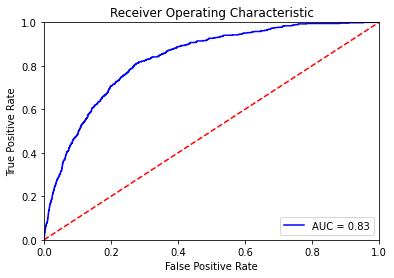

In [118]:
import sklearn.metrics as metrics
y_score = svc.decision_function(X_test)
fpr, tpr, threshold = metrics.roc_curve(y_test,y_score)
roc_curve(fpr,tpr)

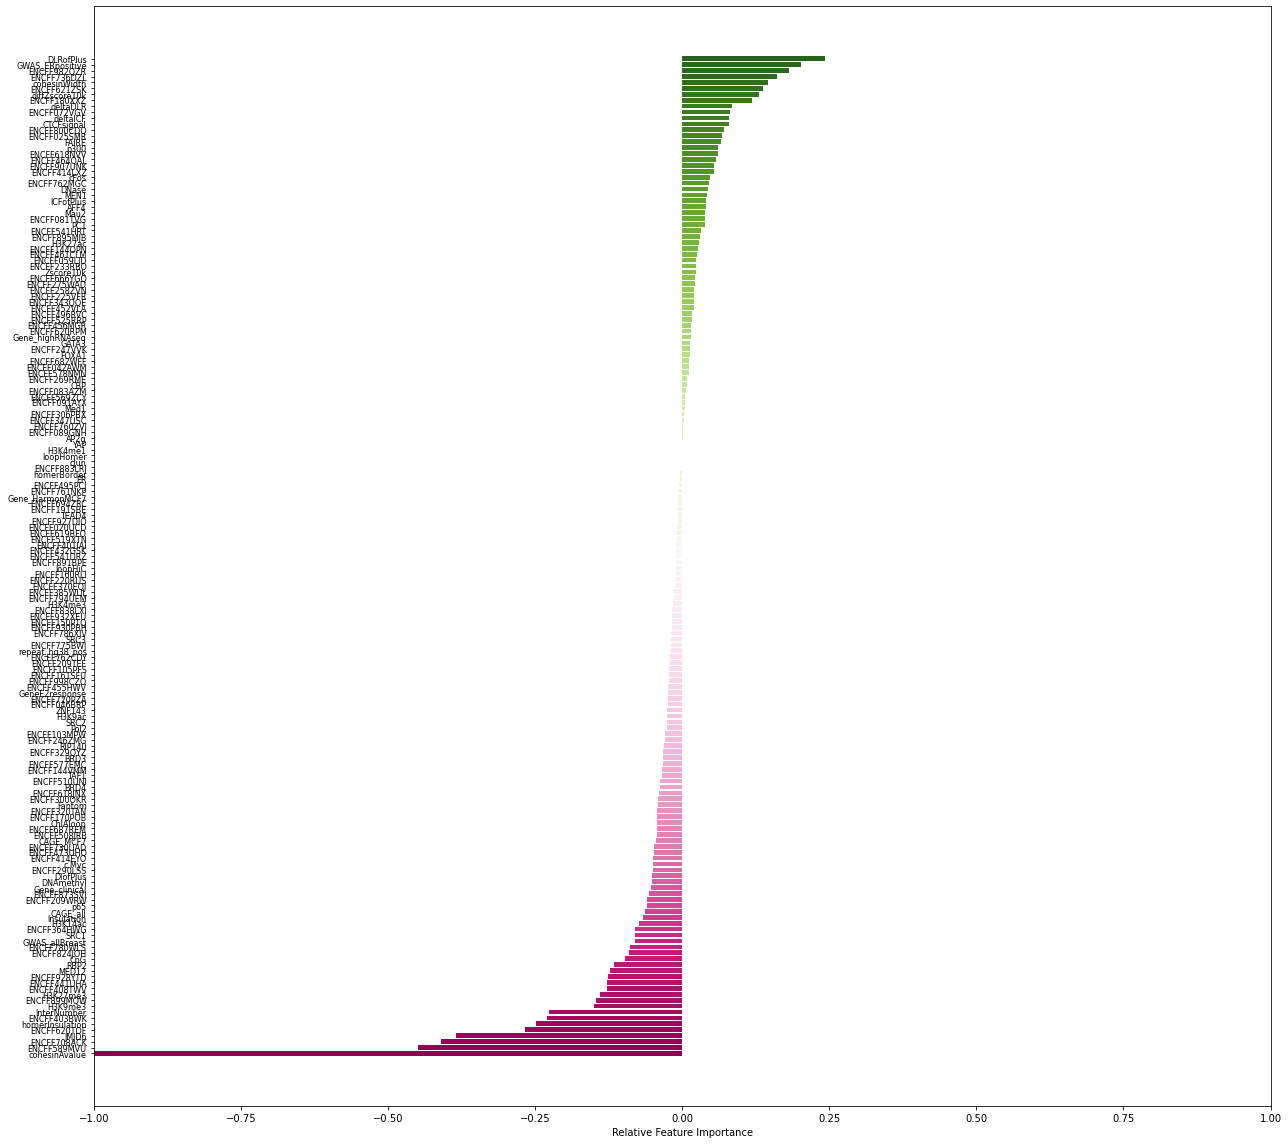

['cohesinAvalue' 'ENCFF589MVU' 'ENCFF708ACK' 'JMJD6' 'ENCFF620TOF'
 'homerInsulation' 'ENCFF403BWK' 'InterNumber' 'H3K9me3' 'ENCFF899MQW'
 'H3K27me3' 'ENCFF408TWV' 'ENCFF441UHA' 'ENCFF928YTD' 'MED12' 'RBP2' 'CpG'
 'ENCFF824JOH' 'ENCFF780WLS' 'GWAS_allBreast' 'SRC1' 'ENCFF364HWG'
 'H3K14ac' 'Insulation' 'CAGE_all' 'p65' 'ENCFF209WRW' 'ENCFF873SVI'
 'Gene_clinical' 'DNAmethyl' 'DIofPlus' 'ENCFF290LSS' 'c.Myc'
 'ENCFF414EYO' 'ENCFF473UHQ' 'ENCFF730UAD' 'CAGE_MCF7' 'ENCFF508JRB'
 'ENCFF687REM' 'ChIAloop' 'ENCFF170POB' 'ENCFF320TAN' 'Fantom'
 'ENCFF300OKR' 'ENCFF618JNX' 'BRD4' 'ENCFF510UNI' 'TAF1' 'ENCFF144VMM'
 'ENCFF577EMC' 'BRD3' 'ENCFF329QYZ' 'RIP140' 'ENCFF246ZMG' 'ENCFF103MPW'
 'Pol2' 'SRC2' 'H3K9ac' 'ZNF143' 'ENCFF046BRP' 'ENCFF720PZA'
 'GeneE2response' 'ENCFF455HWV' 'ENCFF998CZO' 'ENCFF161SFU' 'ENCFF105PFS'
 'ENCFF209TEF' 'ENCFF762CDY' 'repeat_hg38_pos' 'ENCFF775BWJ' 'SRC3'
 'ENCFF786XJV' 'ENCFF930PBH' 'ENCFF150PTQ' 'ENCFF932XEU' 'ENCFF838LXI'
 'H3K4me3' 'ENCFF794UEM' 'ENCFF385WUL' 

In [179]:
importance_plot(svc.coef_[0], X_test)

In [ ]:


lr=LogisticRegression()
paramaters = {'C':np.linspace(1,10, num=10)}
lr_grid = GridSearchCV(lr, paramaters, cv=5, n_jobs=-1, verbose=5) 
lr_grid.fit(X_train_os, y_train_os)